How can we define a max over time loss for an event based snn?

In [4]:
import jax
import jax.numpy as np
from functools import partial
import matplotlib.pyplot as plt

tau_mem = 1e-2
tau_syn = 5e-3
v_th = 0.3
tau_mem_inv = 1 / tau_mem
tau_syn_inv = 1 / tau_syn

t_late = tau_syn + tau_mem
t_max = 2 * t_late

In [5]:
def heaviside(x):
    return 0.5 + 0.5 * np.sign(x)


def kernel(t, t0):
    # neuron dynamics
    A = np.array([[-tau_mem_inv, tau_mem_inv], [0, -tau_syn_inv]])
    return heaviside(t - t0) * jax.scipy.linalg.expm(A * (t - t0))  # type: ignore


def f(t0, x0, t):
    return np.einsum("ijk, ik -> j", jax.vmap(partial(kernel, t))(t0), x0)


def li_cell(weights, inputs, ts):
    spike_times, spike_idx = inputs
    xk = np.stack((np.zeros(4), weights[spike_idx]), axis=1)
    ys = jax.vmap(partial(f, spike_times, xk))(ts)
    return ys

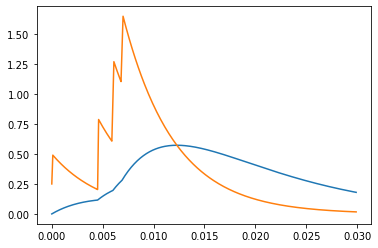

In [6]:
# lets suppose we have the previous spikes as
spike_idx = np.array([0, 1, 2, 1])
spike_times = np.array([0.0, 0.15, 0.2, 0.23]) * t_max

weights = np.array([0.5, 0.6, 0.7])

ts = np.arange(0, t_max, 1e-4)  # time grid to evaluate on
ys = li_cell(weights, (spike_times, spike_idx), ts)
plt.plot(ts, ys)
plt.show()

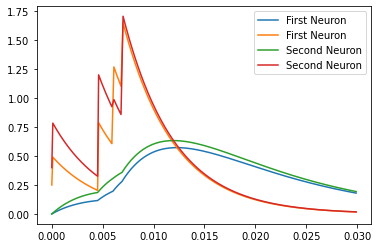

In [7]:
# now do this for two leaky integrate neurons
leaky_integrator = jax.vmap(li_cell, in_axes=(1, None, None), out_axes=1)

weights = np.array(
    [
        [0.5, 0.8],
        [0.6, 0.9],
        [0.7, 0.1],
    ]
)
output = leaky_integrator(weights, (spike_times, spike_idx), ts)
first_neuron, second_neuron = output[:, 0], output[:, 1]
plt.plot(ts, first_neuron, label="First Neuron")
plt.plot(ts, second_neuron, label="Second Neuron")
plt.legend()
plt.show()

In [8]:
# define a max over time loss
def max_over_time(output):
    return np.max(output[::, 0], axis=0)


output = leaky_integrator(weights, (spike_times, spike_idx), ts)
max_v = max_over_time(output)
print(max_v)

[0.57253885 1.6484478 ]


In [9]:
def nll_loss(weights, max_voltage):
    preds = jax.nn.log_softmax(max_voltage)
    loss = -np.sum(targets * preds)
    return loss


def loss_fn(weights, batch):
    output = leaky_integrator(weights, (spike_times, spike_idx), ts)
    max_voltage = max_over_time(output)
    return nll_loss(weights, max_voltage)


spike_idx = np.array([0, 1, 2, 1])
spike_times = np.array([0, 0.2, 0.25, 0.4]) * t_max

inputs = (spike_times, spike_idx)
targets = np.array([1.0, 0.0])
batch = (inputs, targets)
loss_fn(weights, batch)

DeviceArray(1.1077912, dtype=float32)

In [10]:
# can we train this?
weights = np.array(
    [
        [0.5, 0.8],
        [0.6, 0.9],
        [0.7, 0.1],
    ]
)

for i in range(10):
    value, grads = jax.value_and_grad(loss_fn)(weights, batch)
    print(value)
    weights = jax.tree_map(lambda w, dw: w - 0.1 * dw, weights, grads)

1.1077912
1.0802578
1.0534799
1.0274462
1.0021446
0.97756267
0.95368683
0.93050355
0.90908396
0.8960585
